# Load Dependencies 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import Data

In [2]:
train = pd.read_csv('Data/train_features.csv')
test = pd.read_csv('Data/test_features.csv')
target = pd.read_csv('Data/train_labels.csv')
train.shape, test.shape

((59400, 40), (14358, 40))

# Select Features

In [3]:
selected_features = ['amount_tsh',
    'date_recorded',
    'gps_height',
    'basin',
    'region',
    'population',
    'public_meeting',
    'scheme_management',
    'permit',
    'construction_year',
    'extraction_type_class',
    'management_group',
    'payment',
    'quality_group',
    'quantity',
    'source_type',
    'source_class', 
    'waterpoint_type',
    'funder',
    'installer', 
    'latitude',
    'longitude']

def select_features(df, features):
    '''
    Subsets dataframe based on list of columns names accepted 
    as a parameter.
    '''
    return df[features]

In [4]:
train = select_features(train, features=selected_features)
test = select_features(test, features=selected_features)
train.shape, test.shape

((59400, 22), (14358, 22))

# Process Features 

In [5]:
def wrangle_features(X):
    X = X.copy()
    
    # Create month and year features from the recorded data feature
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['date_recorded_month'] = X['date_recorded'].dt.month
    X['date_recorded_year'] = X['date_recorded'].dt.year
    
    # Bin low freq. categories into 'other'
    X['scheme_management'] = X['scheme_management'].replace({
        'SWC':'Other',
        'Trust':'Other',
        'None':'Other'
    })
    
    # Create age category out of construction_year
    # Bin 0 values as -1
    X['pump_age'] = ( 2014 - X['construction_year'] )
    X['pump_age'].replace({2014:-1}).value_counts()
    
    # Alter longitude values so all points are reasonable
    X['longitude'] = X['longitude'].replace({
        0.000000:train['longitude'].median()
    })
    
    # Create Installer Features
    X['DWE_Installer'] = (X['installer'] == 'DWE')

    one_time_install = train['installer'].value_counts()[train['installer'].value_counts() == 1]
    X['One_Time_Installer'] = X['installer'].isin(one_time_install.index)

    small_install = train['installer'].value_counts()[ (train['installer'].value_counts() < 10) & (train['installer'].value_counts() > 1) ]
    X['Small_Installer'] = X['installer'].isin(small_install.index)

    big_install = (( train['installer'].value_counts() >= 10 ) == True)
    X['Big_Installer'] = X['installer'].isin(big_install.index)
    
    # Create Funder Features
    X['Tanzania_Gov_Funder'] = (X['funder'] == 'Government Of Tanzania')

    one_time_funder = train['funder'].value_counts()[train['funder'].value_counts() == 1]
    X['One_Time_Funder'] = X['funder'].isin(one_time_funder.index)

    small_funder = train['funder'].value_counts()[ (train['funder'].value_counts() < 10) & (train['funder'].value_counts() > 1) ]
    X['Small_Funder'] = X['funder'].isin(small_funder.index)

    big_funder = (( train['funder'].value_counts() >= 10 ) == True)
    X['Big_Funder'] = X['funder'].isin(big_funder.index)
    
    # Drop unecessary columns
    drop_cols = ['date_recorded', 'funder', 'installer', 'construction_year']
    X = X.drop(columns=drop_cols)
    
    # Replace population 0 with median population of Train
    median_pop = train['population'].median()
    X['population'] = X['population'].replace(0, median_pop)
    
    return X

In [6]:
test = wrangle_features(test)
train = wrangle_features(train)

train.shape, test.shape

((59400, 29), (14358, 29))

In [7]:
from sklearn.preprocessing import StandardScaler
def standardize(X):
    # Features to standardize
    standardize_cols = ['amount_tsh', 'gps_height', 'longitude', 
                        'latitude', 'population', ]
    
    # Silence Data Conversion warning
    X[standardize_cols] = X[standardize_cols].astype(float)
    
    # Fit and transform scaler
    scaler = StandardScaler()
    scaler.fit(train[standardize_cols])
    scaled = pd.DataFrame( scaler.transform(X[standardize_cols]) )
    
    # Add back column names
    for i in range(len(standardize_cols)):
        scaled = scaled.rename(columns={i:standardize_cols[i]})
        
    # Drop non-standardized columns
    X = X.drop(columns=standardize_cols)
    
    # Concat scaled features with rest of features
    X = pd.concat([X, scaled], axis=1)
    
    return X

In [8]:
train = standardize(train)
test = standardize(test)

train.shape, test.shape

((59400, 29), (14358, 29))

In [9]:
import category_encoders as ce

def one_hot(X):
    # Features to one hot encode
    one_hot_cols = ['date_recorded_month', 'date_recorded_year', 
                    'basin', 'region', 'extraction_type_class', 
                    'management_group', 'payment', 'quality_group', 
                    'quantity', 'source_type', 'source_class', 
                    'waterpoint_type']
    
    # Convert all relevant cols to category datatype (for encoder)
    X[one_hot_cols] = X[one_hot_cols].astype('category')
    
    # Initialize and transform relevant features
    encoder = ce.OneHotEncoder(use_cat_names=True)
    
    # Note, train hardcoded to avoid overfitting test data
    encoder.fit(train[one_hot_cols])
    X = encoder.transform(X[one_hot_cols])
    
    return X

In [10]:
processed_train = one_hot(train)
processed_test = one_hot(test)
processed_train.shape, processed_test.shape

((59400, 94), (14358, 94))

In [33]:
processed_train.to_csv(f'processed_train.csv', index=False)
processed_test.to_csv(f'processed_test.csv', index=False)

# Modeling 

In [11]:
target = pd.read_csv('Data/train_labels.csv')

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(n_estimators=250,
                              max_depth=None, n_jobs=-1)

In [15]:
scores = cross_validate(model, 
                        processed_train, 
                        target['status_group'], 
                        return_train_score=True,
                        return_estimator=True,
                        scoring='accuracy', 
                        n_jobs=-1,
                        cv=5)

In [16]:
pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,53.434053,2.533386,"(DecisionTreeClassifier(class_weight=None, cri...",0.776618,0.821692
1,52.876106,2.407986,"(DecisionTreeClassifier(class_weight=None, cri...",0.772241,0.823165
2,52.955242,2.416070,"(DecisionTreeClassifier(class_weight=None, cri...",0.775758,0.822727
3,53.371311,2.609932,"(DecisionTreeClassifier(class_weight=None, cri...",0.770539,0.823506
4,14.549729,0.640088,"(DecisionTreeClassifier(class_weight=None, cri...",0.771005,0.823366


In [36]:
from sklearn.metrics import accuracy_score

model.fit(processed_train, target['status_group'])

y_train_pred = model.predict(processed_train)
y_test_pred = model.predict(processed_test)

score = accuracy_score(target['status_group'], y_train_pred)
print(f'Train Accuracy Score: {score}')

Train Accuracy Score: 0.8197474747474748


In [49]:
y_test_proba_forest = model.predict_proba(processed_test)
y_test_proba_forest

array([[0.52279365, 0.0156567 , 0.46154965],
       [0.77573171, 0.18619308, 0.03807521],
       [0.64390107, 0.01346719, 0.34263175],
       ...,
       [0.59555961, 0.20672332, 0.19771707],
       [0.97013932, 0.0125254 , 0.01733529],
       [0.        , 0.        , 1.        ]])

# With Boosting

In [37]:
from xgboost import XGBClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [46]:
grboost = XGBClassifier(n_estimators=300,
                        max_depth=5, 
                        silent=False,
                        n_jobs=-1,
)

In [47]:
from sklearn.metrics import accuracy_score

grboost.fit(processed_train, target['status_group'])

y_train_pred = grboost.predict(processed_train)
y_test_pred = grboost.predict(processed_test)

score = accuracy_score(target['status_group'], y_train_pred)
print(f'Train Accuracy Score: {score}')

Train Accuracy Score: 0.7773232323232323


In [50]:
y_test_proba_boost = grboost.predict_proba(processed_test)
y_test_proba_boost

array([[0.32216203, 0.07620762, 0.6016304 ],
       [0.56379443, 0.1118653 , 0.32434025],
       [0.6980914 , 0.13228773, 0.16962093],
       ...,
       [0.630112  , 0.16593882, 0.20394914],
       [0.72117835, 0.14865604, 0.13016562],
       [0.01904117, 0.00215739, 0.9788014 ]], dtype=float32)

In [51]:
avg = (y_test_proba_forest + y_test_proba_boost) / 2

array([[0.42247784, 0.04593216, 0.53159002],
       [0.66976307, 0.14902919, 0.18120773],
       [0.67099623, 0.07287746, 0.25612634],
       ...,
       [0.6128358 , 0.18633107, 0.2008331 ],
       [0.84565883, 0.08059072, 0.07375045],
       [0.00952058, 0.0010787 , 0.98940071]])

# Create Submission 

In [28]:
def create_submission(y_test_pred):
    sample_submission = pd.read_csv('Data/sample_submission.csv')
    submission = sample_submission.copy()
    submission['status_group'] = y_test_pred
    
    now = pd.to_datetime('now')
    filename = 'MB_' + str(now).replace(' ','_')[0:-7] 
    
    submission.to_csv(f'Submissions/{filename}.csv', index=False)

In [41]:
create_submission(y_test_pred)

# Review Feature Importances

In [19]:
def plot_feature_importances(model):
    '''
    Assumes at least 15 features, model must be fitted
    '''
    fi_values = model.feature_importances_
    fi = pd.DataFrame({
        'feature':processed_train.columns,
        'importance':fi_values
    })
    fi['normalized'] = fi['importance'] / fi['importance'].sum()
    fi = fi.sort_values('normalized', ascending=False).reset_index()
    plt.figure(figsize=(10,6))
    ax = plt.subplot()
    ax.barh(list(reversed(list(fi.index[:15]))),
           fi['normalized'].head(15),
           align='center', edgecolor='k')
    ax.set_yticks( list(reversed(list(fi.index[:15]))) )
    ax.set_yticklabels(fi['feature'].head(15))
    ax.set_title('Top 15 Feature Importances')
    plt.show()

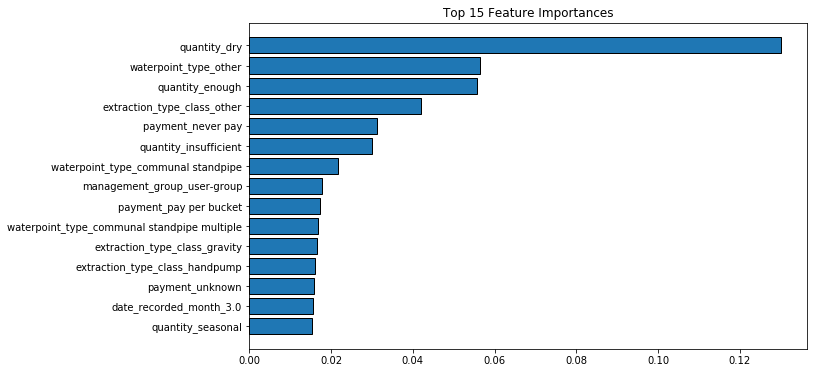

In [22]:
plot_feature_importances(model)

# Max Voting

In [12]:
from sklearn.neighbors import KNeighborsClassifier

km = KNeighborsClassifier(n_jobs=-1, )

km.fit(processed_train, target['status_group'])


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_neighbors': [5, 15, 25],
    'weights': ['uniform', 'distance'],
    'leaf_size': [15, 30, 45],
    'p': [1, 2]
}

search = RandomizedSearchCV(km, 
                           param_distributions=param_distributions,
                           n_iter=10,
                           scoring='accuracy', 
                           verbose=10,
                           cv=3,
                           n_jobs=-1,
                           return_train_score=True)

search.fit(processed_train, target['status_group'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [13]:
pd.DataFrame(search)

0.7838383838383839

In [14]:
from sklearn.ensemble import ExtraTreesClassifier

exf = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, max_depth=8)

exf.fit(processed_train, target['status_group'])

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=8, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [15]:
exf.score(processed_train, target['status_group'])

0.7355050505050506

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=250, verbose=10, max_depth=5, n_iter_no_change=10)

gbc.fit(processed_train, target['status_group'])

      Iter       Train Loss   Remaining Time 
         1       45304.1577            6.98m
         2       43582.5641            6.94m
         3       42242.9043            6.88m
         4       41149.1436            6.85m
         5       40242.0448            6.81m
         6       39457.7825            6.78m
         7       38795.1205            6.76m
         8       38234.3666            6.73m
         9       37754.0571            6.69m
        10       37336.1310            6.64m
        11       36921.9296            6.67m
        12       36582.2395            6.65m
        13       36228.3257            6.64m
        14       35949.7982            6.62m
        15       35653.0108            6.62m
        16       35405.3580            6.63m
        17       35191.8450            6.62m
        18       34959.3288            6.61m
        19       34745.2315            6.59m
        20       34560.2987            6.57m
        21       34409.8831            6.54m
        2

       183       29023.0670            1.74m
       184       29004.8711            1.71m
       185       28991.9011            1.69m
       186       28971.2376            1.66m
       187       28955.0840            1.63m
       188       28945.3964            1.61m
       189       28938.3178            1.58m
       190       28924.6169            1.56m
       191       28913.9302            1.53m
       192       28902.7840            1.50m
       193       28890.6625            1.48m
       194       28877.0894            1.45m
       195       28868.7880            1.42m
       196       28855.5224            1.40m
       197       28843.3481            1.37m
       198       28827.3592            1.35m
       199       28812.0946            1.32m
       200       28800.2100            1.29m
       201       28794.0503            1.27m
       202       28778.5172            1.24m
       203       28768.7141            1.22m
       204       28758.0778            1.19m
       205

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=10, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=10,
                           warm_start=False)

In [17]:
gbc.score(processed_train, target['status_group'])

0.7841919191919192

In [20]:
from sklearn.svm import SVC

sv = SVC(kernel='linear', C=0.025)

sv.fit(processed_train, target['status_group'])

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, max_depth=8, n_jobs=-1)

rf.fit(processed_train, target['status_group'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [23]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('knn', km),
    ('exf', exf),
    ('gbc', gbc),
    ('rf', rf)
]

ensemble = VotingClassifier(estimators, n_jobs=-1, voting='soft')

In [24]:
ensemble.fit(processed_train, target['status_group'])

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('exf',
                              ExtraTreesClassifier(bootstrap=False,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=8,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
   

In [25]:
ensemble.score(processed_train, target['status_group'])

0.7841077441077441

In [26]:
ensemble_test_predict = ensemble.predict(processed_test)

In [29]:
create_submission(ensemble_test_predict)